In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
sns.set_theme(style='ticks')

In [9]:
models = ["meta-llama/Llama-2-7b-hf",
          "meta-llama/Llama-2-13b-hf",
          "mistralai/Mistral-7B-v0.1",
          "lmsys/vicuna-7b-v1.5/",
          "google/gemma-7b/"
]
dataset='rte'

method = 'icl'
attacks = ['textfooler', 'textbugger', 'bert_attack', 'icl_attack', 'swap_labels', 'swap_labels_fix', 'irrelevant_context']
seeds = [1, 13, 42]
# shots = [2, 4, 8, 16]
shots=[8]

results = []

for model in models:
    for attack in attacks:
        for seed in seeds:
            for shot in shots:
                if attack in ['icl_attack', 'swap_labels', 'swap_labels_fix', 'irrelevant_context']:
                    attack_name = 'icl_attack'
                else:
                    attack_name = method

                if attack == 'swap_labels_fix':
                    file = f"./{model}/swap_labels/{attack_name}-seed-{seed}-shot-{shot}/logs_swap_labels_fix_dist.txt"
                else:
                    file = f"./{model}/{attack}/{attack_name}-seed-{seed}-shot-{shot}/logs_{attack}.txt"
                if os.path.isfile(file):
                    with open(file) as f:
                        lines = f.readlines()
                        result = {'seed': seed, 'shot': shot, 'attack': attack, 'method': method, 'model': model}
                        for line in lines:
                            if 'Original accuracy:' in line:
                                result['Clean Acc'] = float(line.split(':')[1].strip().replace('%', '').strip('| '))
                            elif 'Accuracy under attack:' in line:
                                result['Attack Acc'] = float(line.split(':')[1].strip().replace('%', '').strip('| '))
                            elif 'Attack success rate:' in line:
                                result['ASR'] = float(line.split(':')[1].strip().replace('%', '').strip('| '))
                            elif 'Average perturbed word %:' in line:
                                result['Perturbed Word Ratio'] = float(line.split(':')[1].strip().replace('%', '').strip('| '))
                            elif 'Average Attack Perplexity:' in line:
                                result['Attack Perplexity'] = float(line.split(':')[1].strip().strip('| '))
                    results.append(result)
                else:
                    print(file)
                

./meta-llama/Llama-2-7b-hf/textfooler/icl-seed-1-shot-8/logs_textfooler.txt
./meta-llama/Llama-2-7b-hf/textfooler/icl-seed-13-shot-8/logs_textfooler.txt
./meta-llama/Llama-2-7b-hf/textfooler/icl-seed-42-shot-8/logs_textfooler.txt
./meta-llama/Llama-2-7b-hf/textbugger/icl-seed-1-shot-8/logs_textbugger.txt
./meta-llama/Llama-2-7b-hf/textbugger/icl-seed-13-shot-8/logs_textbugger.txt
./meta-llama/Llama-2-7b-hf/textbugger/icl-seed-42-shot-8/logs_textbugger.txt
./meta-llama/Llama-2-7b-hf/icl_attack/icl_attack-seed-13-shot-8/logs_icl_attack.txt
./meta-llama/Llama-2-7b-hf/icl_attack/icl_attack-seed-42-shot-8/logs_icl_attack.txt
./meta-llama/Llama-2-7b-hf/swap_labels/icl_attack-seed-13-shot-8/logs_swap_labels.txt
./meta-llama/Llama-2-7b-hf/swap_labels/icl_attack-seed-42-shot-8/logs_swap_labels.txt
./meta-llama/Llama-2-7b-hf/swap_labels/icl_attack-seed-1-shot-8/logs_swap_labels_fix_dist.txt
./meta-llama/Llama-2-7b-hf/swap_labels/icl_attack-seed-13-shot-8/logs_swap_labels_fix_dist.txt
./meta-llam

In [26]:
df = pd.DataFrame(results)
# drop ASR, Perturbed Word Ratio and Attack Perplexity
# drop nan
df = df.dropna()
# drop method, shot, Perturbed Word Ratio and Attack Perplexity in column
df = df.drop(columns=['method', 'shot', 'Perturbed Word Ratio', 'Attack Perplexity'])

# group by model and attack, compute mean and std across seeds
df = df.groupby(['model', 'attack']).agg({'Clean Acc': ['mean'], 'Attack Acc': ['mean'], 'ASR': ['mean']}).reset_index()
df.columns = ['model', 'attack', 'Clean Acc', 'Attack Acc', 'ASR']
df = df.round(2)

df.loc[len(df)] = ['meta-llama/Llama-2-13b-hf', 'bert_attack', 79.30, 3.42, None]
df.loc[len(df)] = ['meta-llama/Llama-2-7b-hf', 'textbugger', 73.04, 12.75, None]
df.loc[len(df)] = ['meta-llama/Llama-2-7b-hf', 'textfooler', 73.04, 17.81, None]
df.loc[len(df)] = ['meta-llama/Llama-2-7b-hf', 'swap_labels', 73.04, 6.14, None]
df.loc[len(df)] = ['meta-llama/Llama-2-7b-hf', 'swap_labels_fix', 73.04, 30.45, None]
df.loc[len(df)] = ['mistralai/Mistral-7B-v0.1', 'bert_attack', 80.32, 3.42, None]
df.loc[len(df)] = ['mistralai/Mistral-7B-v0.1', 'swap_labels', 80.32, 2.01, None]
df.loc[len(df)] = ['mistralai/Mistral-7B-v0.1', 'swap_labels_fix', 80.32, 32.01, None]
# df.loc[len(df)] = ['google/gemma-7b', 'swap_labels', 81.04,
for model in models:
    df.loc[len(df)] = [model, 'irrelevant_context', 0, 0, 0]
    df.loc[len(df)] = [model, 'icl_attack', 0, 0, 0]

df['model'] = df['model'].map({
    'meta-llama/Llama-2-7b-hf': 'Llama-2-7B',
    'meta-llama/Llama-2-13b-hf': 'Llama-2-13B',
    'mistralai/Mistral-7B-v0.1': 'Mistral-7B',
    'lmsys/vicuna-7b-v1.5/': 'Vicuna-7B',
    'google/gemma-7b/': 'Gemma-7B'
})


attack_order = ['textfooler', 'textbugger', 'bert_attack', 'icl_attack', 'swap_labels', 'swap_labels_fix', 'irrelevant_context']
df['attack'] = pd.Categorical(df['attack'], categories=attack_order, ordered=True)
df = df.sort_values(by='attack')
order = ['Llama-2-7B', 'Llama-2-13B', 'Mistral-7B', 'Vicuna-7B', 'Gemma-7B']
df['model'] = pd.Categorical(df['model'], categories=order, ordered=True)
df = df.sort_values(by='model')

# map attack to human readable name
df['attack'] = df['attack'].map({
    'textfooler': 'TextFooler',
    'textbugger': 'TextBugger',
    'bert_attack': 'BERT-Attack',
    'icl_attack': 'Adv-ICL',
    'swap_labels': 'Swap Labels',
    'swap_labels_fix': 'Swap Labels Fix',
    'irrelevant_context': 'Irrelevant Context'
})

df['ASR'] = ((df['Clean Acc'] - df['Attack Acc']) / df['Clean Acc']) * 100
df = df.round(2)
df['ASR'] = df['ASR'].fillna(0)

df

/var/tmp/ipykernel_1438715/1683860728.py:13: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df.loc[len(df)] = ['meta-llama/Llama-2-13b-hf', 'bert_attack', 79.30, 3.42, None]
/var/tmp/ipykernel_1438715/1683860728.py:14: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df.loc[len(df)] = ['meta-llama/Llama-2-7b-hf', 'textbugger', 73.04, 12.75, None]
/var/tmp/ipykernel_1438715/1683860728.py:15: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future

,model,attack,Clean Acc,Attack Acc,ASR
19,Llama-2-7B,TextFooler,73.04,17.81,75.62
26,Llama-2-7B,Adv-ICL,0.00,0.00,0.00
14,Llama-2-7B,BERT-Attack,73.04,1.56,97.86
18,Llama-2-7B,TextBugger,73.04,12.75,82.54
21,Llama-2-7B,Swap Labels Fix,73.04,30.45,58.31
20,Llama-2-7B,Swap Labels,73.04,6.14,91.59
25,Llama-2-7B,Irrelevant Context,0.00,0.00,0.00
11,Llama-2-13B,Swap Labels Fix,79.30,41.75,47.35
28,Llama-2-13B,Adv-ICL,0.00,0.00,0.00
12,Llama-2-13B,TextBugger,79.30,9.15,88.46


/mnt/data/selection/lib/python3.10/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/mnt/data/selection/lib/python3.10/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/mnt/data/selection/lib/python3.10/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/mnt/data/selection/lib/python3.10/site-packages/seabor

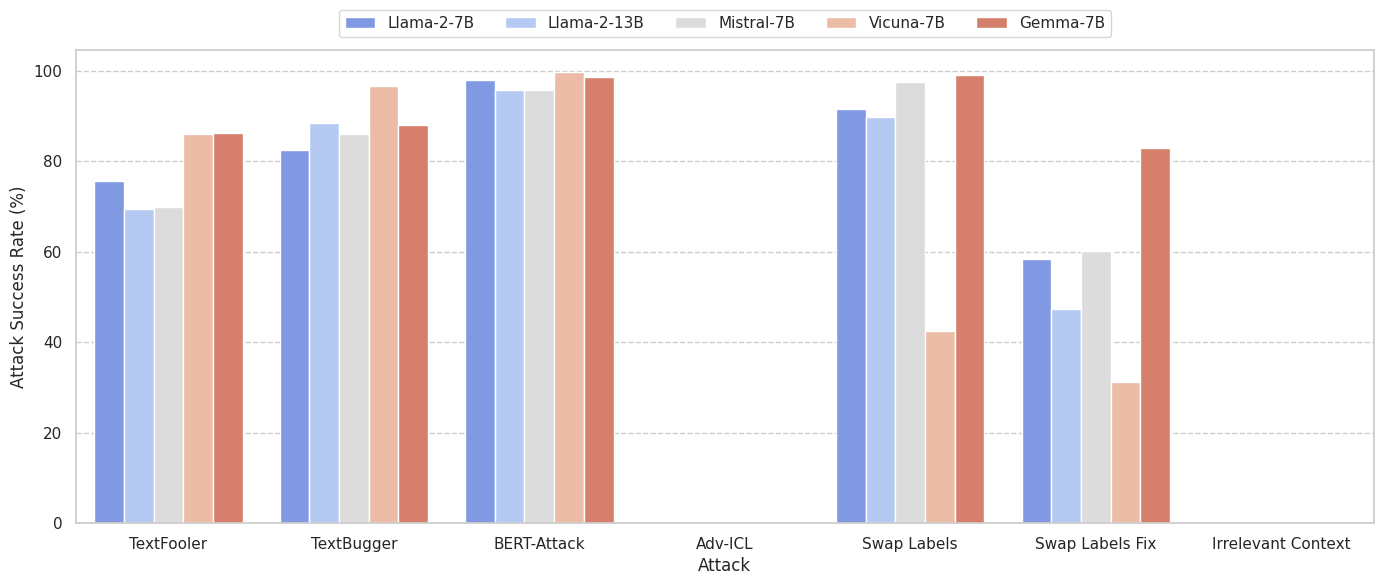

In [64]:
# plot the ASR with x axis as the model, y axis as the ASR, and hue as the attack
fig, ax = plt.subplots(figsize=(14, 6))
sns.set_theme(style="whitegrid")
color_platte = sns.color_palette("Paired")
# reduce the alpha of the color
# color_platte = [color[:3] + (0.9,) for color in color_platte]
# ax = sns.barplot(x="attack", y="ASR", hue="model", data=df, palette=selected_color, alpha=0.6)
ax = sns.barplot(x="attack", y="ASR", hue="model", data=df, palette='coolwarm', width=0.8)
# grey background
# ax.set_facecolor('lightgrey')
# ax.set_title('ASR on RTE with ICL', fontsize=15)
# shift the 
ax.set_ylabel('Attack Success Rate (%)')
ax.set_xlabel('Attack')
# put the legend outside the plot
# plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
# put the legent above the plot
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.1), ncol=len(df['attack'].unique()))
# grid with dotted lines
ax.grid(True, linestyle='--', axis='y')
# save the plot as svg with tight layout
plt.tight_layout()
plt.savefig('ASR.svg')
plt.show()

In [48]:
sns.color_palette("pairs")

ValueError: 'pairs' is not a valid palette name